<a href="https://colab.research.google.com/github/1900690/depth-estimation/blob/main/depth_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##物体検出と組み合わせ（GPU必要）

In [2]:
!git clone https://github.com/apple/ml-depth-pro.git
%cd ml-depth-pro
!pip install -e .
!mkdir checkpoints

Cloning into 'ml-depth-pro'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 45 (delta 7), reused 2 (delta 2), pack-reused 21 (from 1)
Receiving objects: 100% (45/45), 2.50 MiB | 30.13 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/ml-depth-pro
Obtaining file:///content/ml-depth-pro
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.0 MB/s eta 0:00:00

In [3]:
!wget -q -P checkpoints https://huggingface.co/apple/DepthPro/resolve/main/depth_pro.pt
!wget -q https://ultralytics.com/images/bus.jpg

In [4]:
!pip -q install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.2/915.2 kB 37.9 MB/s eta 0:00:00


In [5]:
#@title メモリオーバーするので画像一枚のみしかできない
import numpy as np
from PIL import Image
import time
import torch

from src import depth_pro
#import depth_pro # Since the ml-depth-pro directory is in your PYTHONPATH

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and preprocessing transform
dp_model, transform = depth_pro.create_model_and_transforms()
dp_model = dp_model.to(device)
dp_model.eval()

torch.cuda.synchronize(); start = time.perf_counter()

# Load and preprocess an image.
image, _, f_px = depth_pro.load_rgb("bus.jpg")
image = transform(image).to(device) # Move image to the same device as the model

# Run inference.
with torch.no_grad():
    prediction = dp_model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

np_depth = depth.squeeze().cpu().numpy()

torch.cuda.synchronize(); end = time.perf_counter()
print(f"Inference time: {end - start} sec")

# Save depth map
depth_normalized = (255 - (np_depth - np_depth.min()) / (np_depth.max() - np_depth.min()) * 255).astype(np.uint8)  # depth map normalization
depth_map = Image.fromarray(depth_normalized)
depth_map.show()
depth_map.save("bus_depth_map.jpg")

/content/ml-depth-pro/src/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location="cpu")


Inference time: 5.548492066999984 sec


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 119M/119M [00:01<00:00, 90.5MB/s]



image 1/1 /content/ml-depth-pro/bus.jpg: 640x480 4 persons, 1 bus, 85.0ms
Speed: 16.0ms preprocess, 85.0ms inference, 327.7ms postprocess per image at shape (1, 3, 640, 480)
person: min=3.30[m], avg=4.16[m], max=7.51[m]
person: min=3.64[m], avg=4.31[m], max=10.05[m]
person: min=4.30[m], avg=4.59[m], max=6.81[m]
person: min=2.13[m], avg=2.64[m], max=7.58[m]


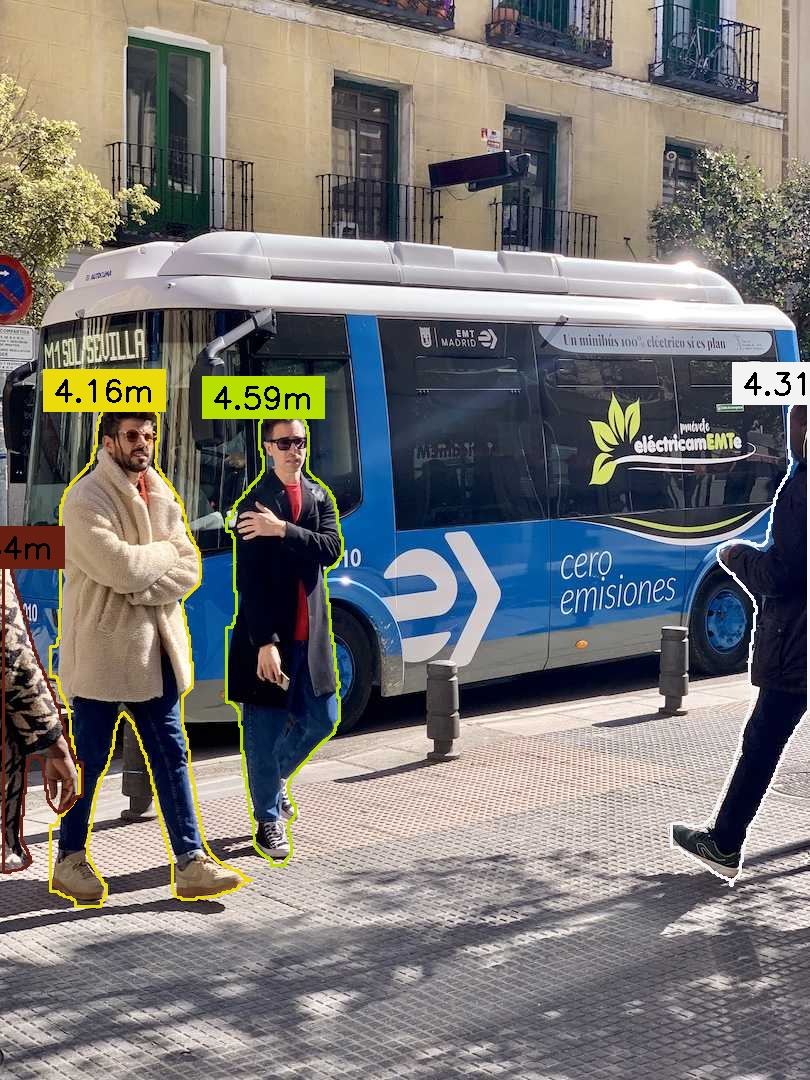

In [6]:
import cv2
from ultralytics import YOLO
from ultralytics.data.utils import polygon2mask
from ultralytics.utils.plotting import Annotator, colors
from google.colab.patches import cv2_imshow


yolo11_seg = YOLO("yolo11x-seg.pt")
yolo_results = yolo11_seg("bus.jpg")
yolo_result = yolo_results[0]

anno = Annotator(cv2.imread("bus.jpg"))

orig_shape = yolo_result.orig_shape
cls_names = yolo_result.names

for i, obj in enumerate(yolo_result):
    cls_name = cls_names[int(obj.boxes.cls.item())]
    if cls_name != "person":
        continue

    box = obj.boxes.xyxy.cpu().numpy()[0]
    mask = polygon2mask(orig_shape, obj.masks.xy)
    # Image.fromarray((mask * 255).astype(np.uint8)).save(f"mask_{i}.png")
    Image.fromarray((mask * depth_map).astype(np.uint8)).save(f"masked_depth_map_{i}.png")
    masked_depth = depth.cpu() * mask

    obj_depth_min = (masked_depth[masked_depth > 0]).min()
    obj_depth_avg = (masked_depth[masked_depth > 0]).mean()
    obj_depth_max = (masked_depth[masked_depth > 0]).max()
    print(f"{cls_name}: min={obj_depth_min:.2f}[m], avg={obj_depth_avg:.2f}[m], max={obj_depth_max:.2f}[m]")
    anno.seg_bbox(obj.masks.xy[0], mask_color=colors(i), label=f"{obj_depth_avg:.2f}m", txt_color=(0, 0, 0))

anno.save("result.jpg")
cv2_imshow(cv2.imread("result.jpg"))